In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [2]:
# import fundamental libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
import time

# preporcessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from pickle import dump

# tesndorflow libraries
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import optimizers, callbacks
from tensorflow.python.keras import backend as K

# from models import resnet
from models import transformer

# from utils import functions
from utils import create_time_series_data, smooth_label, categorical_focal_loss, order_algorithm

In [3]:
# # # load data
# data = pd.read_csv("../data/csv/data.csv", sep = ",")
# print(data.dtypes)

In [4]:
# data.dropna(inplace=True)
# print(len(data))

In [5]:
# data.drop_duplicates(inplace=True)
# print(len(data))

In [6]:
# # # adjust columns type
# data['race_id'] = data['race_id'].astype(str)
# data['order'] = data['order'].astype(str)

In [7]:
# # delete race day information
# data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1, inplace=True)
# # "race_round",
# data.reset_index(drop=True, inplace=True)

In [8]:
# print(data.dtypes)

In [9]:
# # standarlization 
# no_scale_data = data[['race_id','order']]
# scale_columns = data.drop(['race_id','order'], axis=1).columns.values
# standard_scale = StandardScaler()
# data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))

# # PCA
# pca = PCA()
# data = pd.DataFrame(pca.fit_transform(data))
# contrb_rate = pd.DataFrame(pca.explained_variance_ratio_, columns = ['rate'])
# sum_rate = 0

# #  # to get the colum of the specific contribution rate
# # for i in range(len(contrb_rate)):
# #     sum_rate += contrb_rate.rate[i]
# #     if sum_rate >= 0.9:
# #         max_col = i + 1
# #         break

max_col = 84
# # print(max_col)
# data = data.loc[:, :max_col-1]
# print(data.shape[1])
# # print(data.head(5))
# # print(len(data), len(no_scale_data))
# # print(no_scale_data[no_scale_data['race_id'].isnull()])
# data = pd.concat([data, no_scale_data], axis=1)
# dump(standard_scale, open("standard_scale.pkl", "wb"))
# dump(pca, open("pca.pkl", "wb"))

In [10]:
# print(sorted(no_scale_data['order'].unique()))

In [11]:
# print(data.shape)
# print(data.dtypes)
# print(data.head(20))

In [12]:
# def create_time_series_data(raw_data):
#     number_of_race = raw_data.race_id.nunique()
#     time_series_data = np.full((number_of_race, 24, max_col), 0.0)#-float('inf')
#     label = np.full((number_of_race, 24), 25)
#     race_number = 0
#     horse_number = 0
#     for i in range(len(raw_data)):
#         if i == 0:
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#             continue
#         # add new race
#         if data.iloc[i].race_id != data.iloc[i-1].race_id:
#             race_number += 1
#             horse_number = 0
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#         # add new horse to the same race
#         else:
# #             print(data.iloc[i].race_id ,race_number, horse_number)
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#     del raw_data
#     return time_series_data, label

In [13]:
# X, y_order = create_time_series_data(data)
# np.save('X', X)
# np.save('y_order', y_order)
X = np.load('X.npy')
y_order = np.load('y_order.npy')
# del data
print(X.shape)
print(y_order.shape)

(20132, 24, 84)
(20132, 24)


In [14]:
# print(X[0])

In [15]:
X = X.astype('float32')
print(X.dtype)

float32


In [16]:
print(X[0][11])
print(y_order[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 7 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [17]:
alpha = len(y_order) / pd.DataFrame(y_order.flatten()).value_counts()
alpha = alpha.sort_index()
alpha = np.array(alpha)
alpha = np.append(0,alpha)
print(alpha.shape)
print(alpha)

(26,)
[0.00000000e+00 1.21687621e+00 1.21555368e+00 1.23063757e+00
 1.24041898e+00 1.25990362e+00 1.26100846e+00 1.28155834e+00
 1.32325490e+00 1.37157651e+00 1.45736210e+00 1.56413643e+00
 1.73521807e+00 1.98052140e+00 2.27608819e+00 2.71833648e+00
 3.58156912e+00 1.49347181e+01 2.00918164e+01 1.25825000e+03
 1.43800000e+03 2.51650000e+03 3.35533333e+03 4.02640000e+03
 5.03300000e+03 7.53440294e-02]


In [18]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order, dtype='float32')
print(y[5])
print(y.shape)
print(X.shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0.

In [19]:
# def smooth_label(label, factor=0.03):
#     # smooth label
#     label *= (1 - factor)
# #     label[:,:,1:4] += (factor / 3)

#     for i in range(label.shape[0]):
#         for j in range(label.shape[1]):
#             t = np.where(label[i][j] == 1 - factor)
#             label[i,j,max(0,t[0][0]-1):min(26,t[0][0]+2)] += (factor / 3)
#     return label

In [20]:
y = smooth_label(y) 
print(y[4])
print(y.shape)
print(X.shape)

[[0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

In [21]:
# print(data.race_id.value_counts().plot.hist(bins=25,range=(1,25)))

AxesSubplot(0.125,0.125;0.775x0.755)


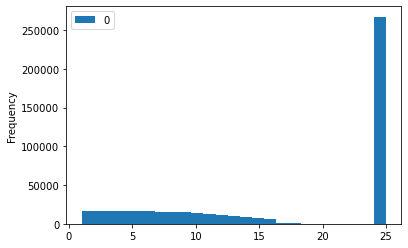

In [22]:
print(pd.DataFrame(y_order.flatten()).plot.hist(bins=25))## ,ylim=(0,1000)

In [23]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.01, random_state = 0)
del X, y

In [24]:
print(X_train[0][1])

[-5.0841513e+00  7.0771635e-02 -5.8418870e-01  2.4646287e-01
  1.8285137e+00 -1.1262701e+00  6.5735537e-01  1.5329328e+00
  6.2066919e-01 -6.7069030e-01  1.0873965e+00  1.7795300e-01
 -2.2035263e+00 -5.5455178e-01  1.5312845e+00  1.9849390e+00
 -1.9881687e+00 -4.5285341e-01 -1.1557992e+00  3.0845302e-01
  6.5695131e-01 -1.6801572e+00  1.2509111e-01 -6.3480353e-01
  2.6424465e-01 -1.8350914e+00  1.3959821e+00 -1.1001785e+00
 -2.4194989e+00  2.9623857e+00  1.4317343e+00  1.9310854e-02
  3.4215423e-01  7.4966168e-01 -1.0088371e+00  8.0969352e-01
 -2.5986239e-01 -8.4669787e-01  1.0779321e+00  6.1363038e-02
 -1.5148355e+00 -1.8475902e-03 -8.8226789e-01 -6.8742210e-01
 -2.6793274e-01  1.6574528e+00 -2.0822718e+00 -1.7538213e+00
  4.2922177e+00  1.6022534e+00 -4.4454589e-01 -6.7625672e-01
 -8.8914499e-02 -1.1668312e-01 -3.3394665e-01 -7.5860035e-01
  3.7061727e-01 -6.4284933e-01  3.2509527e-01  4.8748016e-01
  1.5954223e+00  1.4406800e-01 -8.7014019e-01  6.6753399e-01
 -1.0578674e+00  4.23975

In [25]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(19930, 24, 84)
(202, 24, 84)
(19930, 24, 26)
(202, 24, 26)


In [26]:
# def categorical_focal_loss(alpha, gamma):
#     """
#     Softmax version of focal loss.
#     When there is a skew between different categories/labels in your data set, you can try to apply this function as a
#     loss.
#            m
#       FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
#           c=1
#       where m = number of classes, c = class and o = observation
#     Parameters:
#       alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
#       categories/labels, the size of the array needs to be consistent with the number of classes.
#       gamma -- focusing parameter for modulating factor (1-p)
#     Default value:
#       gamma -- 2.0 as mentioned in the paper
#       alpha -- 0.25 as mentioned in the paper
#     References:
#         Official paper: https://arxiv.org/pdf/1708.02002.pdf
#         https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
#     Usage:
#      model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
#     """

#     alpha = np.array(alpha, dtype=np.float32)

#     def categorical_focal_loss_fixed(y_true, y_pred):
#         """
#         :param y_true: A tensor of the same shape as `y_pred`
#         :param y_pred: A tensor resulting from a softmax
#         :return: Output tensor.
#         """

#         # Clip the prediction value to prevent NaN's and Inf's
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

#         # Calculate Cross Entropy
#         cross_entropy = -y_true * K.log(y_pred)

#         # Calculate Focal Loss
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

#         # Compute mean loss in mini_batch
#         return K.mean(K.sum(loss, axis=-1))

#     return categorical_focal_loss_fixed

In [27]:
# creating dataset with batch size
batch_size = 2048 # hyperparameter 2048
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=19930).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=202).batch(batch_size)


del X_train, y_train

In [28]:
# set up parameters
num_layers = 16 # hyperparameter
d_model = max_col # 4*35 84=4*3*7
num_heads = 4 # hyperparameter *must be a factor of d_model* 28
d_ffn = 1024 # hyperparameter
pe_input = 24
target_size = 26
dropout_rate = 0.1 # hyperparameter

In [29]:
# set up model
trans_race = transformer.TransRace(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ffn=d_ffn,
    pe_input=pe_input,
    target_size=target_size,
    rate=dropout_rate,
)
opt = optimizers.Adam(decay=0.001) # 0.01
loss = categorical_focal_loss(alpha=[alpha], gamma=0.5) # gammma-0.5

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
trans_race.compile(
    optimizer=opt,
    loss=loss,#'categorical_crossentropy', # 'sigmoid_focal_crossentropy'
    metrics=['accuracy'], #['categorical_accuracy']
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='../models/results/transformer.h5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
)

history = trans_race.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1000,
    verbose=True, # hide the output because we have so many epochs
    callbacks=[model_checkpoint_callback]
)
print(trans_race.summary())
# trans_race.save_weights("../models/results/transformer.h5")

    def call(self, inputs, training):
        inp = inputs

        enc_padding_mask = self.create_masks(inp) #, tar
        # , look_ahead_mask, dec_padding_mask

        enc_output = self.encoder(inp, training, enc_padding_mask)
#         print("enc output shape", enc_output.shape)

        final_output = self.final_layer(enc_output)
#         print("final output shape", final_output.shape)
        
        return final_output

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, inputs, training):
        inp = inputs

        enc_padding_mask = self.create_masks(inp) #, tar
        # , look_ahead_mask, dec_padding_mask

        enc_output = self.encoder(inp, training, enc_padding_mask)
#         print("enc output shape", enc_output.shape)

        final_output = self.final_layer(enc_output)
#         print("final output shape", final_output.shape)
        
        return final_output

This may be caused by multiline stri

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print(x.shape,"mha")
        attn_output = self.mha(x, x, x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, 

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10 steps, validate on 1 steps
Epoch 1/1000
10/10 [==============================] - 24s 2s/step - loss: 3.3828 - acc: 0.0257 - val_loss: 3.1817 - val_acc: 0.0239
Epoch 2/1000
10/10 [==============================] - 8s 778ms/step - loss: 3.0234 - acc: 0.0742 - val_loss: 3.0345 - val_acc: 0.0303
Epoch 3/1000
10/10 [==============================] - 8s 758ms/step - loss: 2.9363 - acc: 0.0499 - val_loss: 3.3781 - val_acc: 

10/10 [==============================] - 7s 739ms/step - loss: 2.8555 - acc: 0.1078 - val_loss: 3.0322 - val_acc: 0.5357
Epoch 52/1000
10/10 [==============================] - 7s 741ms/step - loss: 2.8715 - acc: 0.1013 - val_loss: 3.0846 - val_acc: 0.5357
Epoch 53/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.1184 - acc: 0.0785 - val_loss: 3.2848 - val_acc: 0.0326
Epoch 54/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.6299 - acc: 0.0115 - val_loss: 3.1587 - val_acc: 2.0627e-04
Epoch 55/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.4085 - acc: 0.0112 - val_loss: 3.4424 - val_acc: 0.0000e+00
Epoch 56/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.4651 - acc: 0.0240 - val_loss: 3.4860 - val_acc: 0.0322
Epoch 57/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.3162 - acc: 0.0304 - val_loss: 3.4487 - val_acc: 0.0351
Epoch 58/1000
10/10 [==============================] - 7s 740

10/10 [==============================] - 7s 739ms/step - loss: 3.2872 - acc: 0.1214 - val_loss: 3.4418 - val_acc: 0.5421
Epoch 112/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.3706 - acc: 0.1349 - val_loss: 3.4080 - val_acc: 0.5421
Epoch 113/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.2961 - acc: 0.0605 - val_loss: 3.3885 - val_acc: 0.5421
Epoch 114/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.2693 - acc: 0.0919 - val_loss: 3.4417 - val_acc: 0.5421
Epoch 115/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.3394 - acc: 0.1599 - val_loss: 3.4216 - val_acc: 0.5421
Epoch 116/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.2829 - acc: 0.0885 - val_loss: 3.4312 - val_acc: 0.5421
Epoch 117/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.2959 - acc: 0.1435 - val_loss: 3.4688 - val_acc: 0.5421
Epoch 118/1000
10/10 [==============================] - 7s 739m

10/10 [==============================] - 7s 742ms/step - loss: 3.2221 - acc: 0.1228 - val_loss: 3.4286 - val_acc: 0.5421
Epoch 172/1000
10/10 [==============================] - 8s 751ms/step - loss: 3.2551 - acc: 0.1508 - val_loss: 3.4766 - val_acc: 0.5421
Epoch 173/1000
10/10 [==============================] - 7s 740ms/step - loss: 3.1523 - acc: 0.2411 - val_loss: 3.4950 - val_acc: 0.5421
Epoch 174/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.2590 - acc: 0.2089 - val_loss: 3.4246 - val_acc: 0.5421
Epoch 175/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.2787 - acc: 0.1570 - val_loss: 3.4109 - val_acc: 0.5421
Epoch 176/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.1272 - acc: 0.1897 - val_loss: 3.4195 - val_acc: 0.5421
Epoch 177/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.3462 - acc: 0.1835 - val_loss: 3.4357 - val_acc: 0.5421
Epoch 178/1000
10/10 [==============================] - 7s 738m

10/10 [==============================] - 7s 738ms/step - loss: 3.2410 - acc: 0.1465 - val_loss: 3.5053 - val_acc: 0.5421
Epoch 232/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.2162 - acc: 0.1715 - val_loss: 3.4939 - val_acc: 0.5421
Epoch 233/1000
10/10 [==============================] - 7s 748ms/step - loss: 3.2506 - acc: 0.1803 - val_loss: 3.4837 - val_acc: 0.5421
Epoch 234/1000
10/10 [==============================] - 8s 798ms/step - loss: 3.2105 - acc: 0.1594 - val_loss: 3.4836 - val_acc: 0.5421
Epoch 235/1000
10/10 [==============================] - 8s 799ms/step - loss: 3.2364 - acc: 0.1741 - val_loss: 3.5055 - val_acc: 0.5421
Epoch 236/1000
10/10 [==============================] - 8s 799ms/step - loss: 3.2597 - acc: 0.1551 - val_loss: 3.5231 - val_acc: 0.5421
Epoch 237/1000
10/10 [==============================] - 8s 799ms/step - loss: 3.2319 - acc: 0.2987 - val_loss: 3.5173 - val_acc: 0.5421
Epoch 238/1000
10/10 [==============================] - 7s 746m

10/10 [==============================] - 7s 737ms/step - loss: 3.0287 - acc: 0.2491 - val_loss: 3.6151 - val_acc: 0.5421
Epoch 292/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.1865 - acc: 0.2132 - val_loss: 3.5937 - val_acc: 0.5421
Epoch 293/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0934 - acc: 0.1556 - val_loss: 3.5708 - val_acc: 0.5421
Epoch 294/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.1528 - acc: 0.1952 - val_loss: 3.5814 - val_acc: 0.5421
Epoch 295/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0650 - acc: 0.1966 - val_loss: 3.6065 - val_acc: 0.5421
Epoch 296/1000
10/10 [==============================] - 7s 736ms/step - loss: 3.2281 - acc: 0.1820 - val_loss: 3.5766 - val_acc: 0.5421
Epoch 297/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.1123 - acc: 0.1535 - val_loss: 3.5840 - val_acc: 0.5421
Epoch 298/1000
10/10 [==============================] - 7s 737m

10/10 [==============================] - 7s 736ms/step - loss: 3.1833 - acc: 0.2028 - val_loss: 3.6937 - val_acc: 0.5421
Epoch 352/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0787 - acc: 0.1622 - val_loss: 3.7135 - val_acc: 0.5421
Epoch 353/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.1134 - acc: 0.1860 - val_loss: 3.7273 - val_acc: 0.5421
Epoch 354/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0911 - acc: 0.1822 - val_loss: 3.7420 - val_acc: 0.5421
Epoch 355/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0877 - acc: 0.1793 - val_loss: 3.7428 - val_acc: 0.5421
Epoch 356/1000
10/10 [==============================] - 7s 736ms/step - loss: 3.0154 - acc: 0.2108 - val_loss: 3.7128 - val_acc: 0.5421
Epoch 357/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0787 - acc: 0.1847 - val_loss: 3.6752 - val_acc: 0.5421
Epoch 358/1000
10/10 [==============================] - 7s 737m

10/10 [==============================] - 7s 736ms/step - loss: 2.9592 - acc: 0.1523 - val_loss: 3.8015 - val_acc: 0.0000e+00
Epoch 412/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0980 - acc: 0.1985 - val_loss: 3.7777 - val_acc: 0.0000e+00
Epoch 413/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0120 - acc: 0.1435 - val_loss: 3.7978 - val_acc: 0.0000e+00
Epoch 414/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.1205 - acc: 0.1839 - val_loss: 3.7736 - val_acc: 0.0000e+00
Epoch 415/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0113 - acc: 0.1385 - val_loss: 3.7864 - val_acc: 0.0000e+00
Epoch 416/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.1353 - acc: 0.1847 - val_loss: 3.7693 - val_acc: 0.5421
Epoch 417/1000
10/10 [==============================] - 7s 736ms/step - loss: 3.0282 - acc: 0.1303 - val_loss: 3.7924 - val_acc: 0.5421
Epoch 418/1000
10/10 [=====================

Epoch 470/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.1061 - acc: 0.1588 - val_loss: 3.8653 - val_acc: 0.0000e+00
Epoch 471/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.0038 - acc: 0.1758 - val_loss: 3.9099 - val_acc: 0.0000e+00
Epoch 472/1000
10/10 [==============================] - 7s 741ms/step - loss: 3.0432 - acc: 0.1706 - val_loss: 3.8942 - val_acc: 0.0000e+00
Epoch 473/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.0528 - acc: 0.1346 - val_loss: 3.9223 - val_acc: 0.0000e+00
Epoch 474/1000
10/10 [==============================] - 7s 738ms/step - loss: 3.0830 - acc: 0.1808 - val_loss: 3.8758 - val_acc: 0.0000e+00
Epoch 475/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.1247 - acc: 0.1307 - val_loss: 3.8614 - val_acc: 0.0000e+00
Epoch 476/1000
10/10 [==============================] - 7s 739ms/step - loss: 3.0249 - acc: 0.1544 - val_loss: 3.8617 - val_acc: 0.0000e+00
Epoch 477/1000
 8/10

In [ ]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='lower right')
# figureの保存
# plt.savefig("../models/results/trans_race_result.png")

In [ ]:
# predict

preds = trans_race.predict(X_valid)
y_pred = np.argmax(preds, axis = 2)
y_ans = np.argmax(y_valid, axis = 2)


In [ ]:
# def order_algorithm(preds):
#     num_race = preds.shape[0]
#     y_preds = np.full((num_race, 24), 25)
#     for i in range(num_race):
#         one_race = preds[i,:,:]
#         init_preds = np.argmax(one_race, axis = -1)
#         exist_horse = np.delete(one_race, np.where(init_preds == 25)[0], 0)
#         for j in range(1,exist_horse.shape[0]+1):
#             one_order = np.argmax(exist_horse[:,j])
#             for k in range(one_race.shape[0]):
#                 if np.array_equal(one_race[k], exist_horse[one_order]):
#                     y_preds[i][k] = j
#                     exist_horse = np.delete(exist_horse, one_order, 0)
#                     break
#     return y_preds

In [ ]:
# print(pd.DataFrame(preds[0]))

In [ ]:
# def order_algorithm(preds):
#     num_race = preds.shape[0]
#     y_preds = np.full((num_race, 24), 25)
#     for i in range(num_race): # iterate all race
#         one_race = preds[i,:,:] # shape = (24, 26) ,so (num of horse, num of target 0-25)
#         init_preds = np.argmax(one_race, axis = -1)
#         exist_horse = np.delete(one_race, np.where(init_preds == 25)[0], 0) # shape = (num of exist horse, 26)
#         for j in range(1,exist_horse.shape[0]+1): # iterate 1-num of exist horse
#             one_order = np.argmax(exist_horse[:,j]) # this is a target order
#             for k in range(one_race.shape[0]): # search the horse k = (0, 23)
#                 if np.array_equal(one_race[k], exist_horse[one_order]):
#                     y_preds[i][k] = j
#                     exist_horse = np.delete(exist_horse, one_order, 0)
#                     exist_horse[:,j+1] += exist_horse[:,j]
#                     one_race[:,j+1] += one_race[:,j]
#                     break
#     return y_preds

In [ ]:
y_preds = order_algorithm(preds)
print(y_preds.shape)
print(y_preds[0])

In [ ]:
print(preds.shape)
print(y_preds.shape)
print(y_ans.shape)


In [ ]:
print(y_ans[0])
print(y_preds[0])
print(y_pred[0])
# print(np.mean(y_pred))

In [ ]:
correct = 0
for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_preds[i][j] == y_ans[i][j]):
            correct += 1
accuracy = correct / len(y_pred)
print("accuracy: ", accuracy)

In [ ]:
# the distribution of prediction
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['0','1','2','3','4','5','6','7','8','9',' 10',' 11',' 12',' 13',' 14',' 15',' 16',' 17',' 18',' 19',' 20',' 21',' 22',' 23',' 24']

axL.hist(y_preds.flatten(), bins = 25, label = "pred_order")##, range = (1,21)
axL.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(y_ans.flatten(), bins = 25, label = "ans_order")##, range = (1,21)
axR.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [ ]:
# precision = TP / (TP + FP)
# the accuracy of predected True
i = 0
correct_first = 0
all_f = 0
increase = 0
# X_valid_inv = standard_scale.inverse_transform(X_valid)
# X_valid_inv_df = pd.DataFrame(X_valid_inv)
# odds = X_test_inv_df['odds'].values
# hit_odds = []
# select = []

for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_preds[i][j] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
            all_f += 1
            if (y_ans[i][j] == 1) or (y_ans[i][j] == 2) or (y_ans[i][j] == 3):
                correct_first += 1   #　True Positive
            
# for i in range(len(y_ans)):
#     if (y_preds[i] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
#         all_f = all_f + 1
#         if (y_ans[i] == 1):
#             correct_first = correct_first + 1   #　True Positive
# #             increase += odds[i]
# #             hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
# print("hit odds average: ", np.array(hit_odds).mean())
# print("spent money:", all_f * 100)
# revenue = (increase - all_f) * 100
# retrive = increase / all_f
 
# print("retrive rate: ", retrive) 
# print("revenue: ", revenue)
precision = correct_first / all_f
print("precision: ",precision)
#print("\n".join(map(str,hit_odds)))
# print("min: ", min(hit_odds))
# print("mid: ", np.median(np.array(hit_odds)))
# print("max: ", max(hit_odds))

# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# axL.hist(hit_odds, bins = 50, label = "hit_odds")
# axL.set_title('hit odds distribution')
# axL.legend()
# axR.hist(odds, bins = 50, label = "odds", range = (0,40))
# axR.set_title('all odds distribution')
# axR.legend()
# fig.show()


In [ ]:
# Recall = TP / (TP + FN)
# the accuracy of label True
i = 0
correct_first = 0
all_f = 0
# odds_f = []
p_rate_f = []

# all_f_odds = []

for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_ans[i][j] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
            all_f += 1
            if (y_preds[i][j] == 1):
                correct_first += 1   #　True Positive
                
                
# for i in range(len(y_ans)):
#     if (y_ans[i] == 1):  # TP + FN
#         all_f = all_f + 1
# #         all_f_odds.append(odds[i])
#         if (y_preds[i] == 1):
#             correct_first = correct_first + 1   #　TP
#             odds_f.append(odds[i])
#             p_rate_f.append(pred[i][1])

# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# axL.scatter(p_rate_f, odds_f)  
# axL.set_title('correlation odss and prediction')
# #axL.xlabel('prediction rate first')
# #axL.ylabel('odds')
# axR.hist(odds_f, bins = 50, label = "odds")
# axR.set_title('all first odds distribution')
# axR.legend()

# fig.show()
Recall = correct_first / all_f
print("Recall: ",Recall)
# print("all_f_odds average: ", np.array(all_f_odds).mean())



In [ ]:
# 3 renpuku
within_3 = 0
hit = 0

for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        within_3 += 1
        if (y_ans[i][j] == 1) or (y_ans[i][j] == 2) or (y_ans[i][j] == 3):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
            if (y_preds[i][j] == 1) or (y_preds[i][j] == 2) or (y_preds[i][j] == 3) or (y_preds[i][j] == 4):
                hit += 1   #　True Positive
                
precision = hit / within_3
print("precision of 3 renpuku: ", precision)